### Notebook for the label transfer of WT mice to genotypes with `scANVI`

- **Developed by:** Carlos Talavera-López Ph.D
- **Würzburg Institute for Systems Immunology - Faculty of Medicine - Julius-Maximilian-Universität Würzburg**
- v230829

### Import required modules

In [1]:
import torch
import scvi
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from scib_metrics.benchmark import Benchmarker

/Users/cartalop/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/Users/cartalop/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/Users/cartalop/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/flax/struct.py:133: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/cartalop/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/flax/struct.py:133: FutureWarning: jax.tree_util.register_keypaths is depreca

### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.8.0
scanpy      1.9.3
-----
PIL                 9.4.0
absl                NA
aiohttp             3.8.4
aiosignal           1.3.1
anyio               NA
appnope             0.1.3
asttokens           NA
async_timeout       4.0.2
attr                23.1.0
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
brotli              NA
bs4                 4.12.2
certifi             2022.12.07
cffi                1.15.1
charset_normalizer  2.1.1
chex                0.1.6
click               8.1.3
colorama            0.4.6
contextlib2         NA
croniter            NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.6
decorator           5.1.1
deepdiff            6.3.0
docrep              0.3.2
executing           1.2.0
fastapi             0.99.1
flax                0.5.0
frozenlist          1.3.3
fsspec              2023.3.0
h5py                3.8.0
hypergeom_ufunc     NA
idna                3.4
igraph   

In [3]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'
torch.set_float32_matmul_precision('medium')

Global seed set to 1712


In [4]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 3,
)

### Read in data

In [5]:
heart_scANVI = sc.read_h5ad('../data/heart_mm_nuclei-23-0092_scANVi-annot_ctl230829.raw.h5ad')
heart_scANVI

AnnData object with n_obs × n_vars = 334961 × 14249
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids-query', 'feature_types-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-query', 'mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'gene_ids-Harvard-Nuclei-full-reference', 'feature_types-Harvard-Nuclei-full-reference', 'gene_ids-Sanger-Nuclei-full-reference', 'feature_types-Sanger-Nuclei-full-reference', 'gene_ids-Sanger-Cells-full-reference', 'feature_types-Sanger-Cells-full-reference', 'gene_ids-Sanger-CD45-full-reference', 'feature_types-Sanger-CD45-full-refere

In [6]:
heart_scANVI.obs_names = [name.rsplit('-', 1)[0] for name in heart_scANVI.obs_names]
heart_scANVI.obs_names

Index(['AAACCCAAGAAGGTAG-1-A9_2', 'AAACCCAAGAGAGTGA-1-A9_2',
       'AAACCCAAGATGGCAC-1-A9_2', 'AAACCCAAGCACGTCC-1-A9_2',
       'AAACCCAAGCCTAACT-1-A9_2', 'AAACCCAAGCCTCGTG-1-A9_2',
       'AAACCCAAGGAATGTT-1-A9_2', 'AAACCCAAGGCCATAG-1-A9_2',
       'AAACCCAAGGCCGCTT-1-A9_2', 'AAACCCAAGGGCAGTT-1-A9_2',
       ...
       'TTTGTTGGTGGCCTCA-1-B2_2', 'TTTGTTGGTGTCCCTT-1-B2_2',
       'TTTGTTGGTTGGTACT-1-B2_2', 'TTTGTTGTCATTTGTC-1-B2_2',
       'TTTGTTGTCCGACAGC-1-B2_2', 'TTTGTTGTCCTACACC-1-B2_2',
       'TTTGTTGTCCTACCGT-1-B2_2', 'TTTGTTGTCGCTGTCT-1-B2_2',
       'TTTGTTGTCTCGCCTA-1-B2_2', 'TTTGTTGTCTCTCTTC-1-B2_2'],
      dtype='object', length=334961)

### Add the full gene set from the original object

In [7]:
heart_original = sc.read('../data/heart_mm_nuclei-23-0092_QCed_ctl230828.raw.h5ad')
heart_original.obs_names

Index(['AAACCCAAGAAGGTAG-1-A9_2', 'AAACCCAAGAGAGTGA-1-A9_2',
       'AAACCCAAGATGGCAC-1-A9_2', 'AAACCCAAGCACGTCC-1-A9_2',
       'AAACCCAAGCCTAACT-1-A9_2', 'AAACCCAAGCCTCGTG-1-A9_2',
       'AAACCCAAGGAATGTT-1-A9_2', 'AAACCCAAGGCCATAG-1-A9_2',
       'AAACCCAAGGCCGCTT-1-A9_2', 'AAACCCAAGGGCAGTT-1-A9_2',
       ...
       'TTTGTTGGTGGCCTCA-1-B2_2', 'TTTGTTGGTGTCCCTT-1-B2_2',
       'TTTGTTGGTTGGTACT-1-B2_2', 'TTTGTTGTCATTTGTC-1-B2_2',
       'TTTGTTGTCCGACAGC-1-B2_2', 'TTTGTTGTCCTACACC-1-B2_2',
       'TTTGTTGTCCTACCGT-1-B2_2', 'TTTGTTGTCGCTGTCT-1-B2_2',
       'TTTGTTGTCTCGCCTA-1-B2_2', 'TTTGTTGTCTCTCTTC-1-B2_2'],
      dtype='object', length=351093)

In [8]:
heart_original

AnnData object with n_obs × n_vars = 351093 × 32285
    obs: 'sample', 'genotype', 'batch', 'n_genes', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'genotype_colors', 'sample_colors'
    layers: 'counts', 'sqrt_norm'

### Add full genes

In [9]:
heart_new = heart_original[heart_scANVI.obs_names]
heart_new

View of AnnData object with n_obs × n_vars = 334961 × 32285
    obs: 'sample', 'genotype', 'batch', 'n_genes', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'genotype_colors', 'sample_colors'
    layers: 'counts', 'sqrt_norm'

In [10]:
heart_new.obs = heart_scANVI.obs.copy()
heart_new

AnnData object with n_obs × n_vars = 334961 × 32285
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'genotype_colors', 'sample_colors'
    layers: 'counts', 'sqrt_norm'

In [11]:
heart_new.obs['seed_labels'] = heart_new.obs['C_scANVI'].copy()
del(heart_new.obs['C_scANVI'])
heart_new

AnnData object with n_obs × n_vars = 334961 × 32285
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'genotype_colors', 'sample_colors'
    layers: 'counts', 'sqrt_norm'

In [12]:
heart_new.obs['seed_labels'].value_counts()

Adipocytes                   94370
Neuronal                     84823
Endothelial                  47946
Lymphoid                     39719
Pericytes                    19436
Atrial_Cardiomyocyte         17225
Ventricular_Cardiomyocyte    14310
Fibroblast                   13430
Smooth_muscle_cells           3702
Name: seed_labels, dtype: int64

### Read in other unannotated dataset and split into groups

In [13]:
heart_new.obs['genotype'].value_counts()

WT         127688
Mdx        123988
MdxSCID     83285
Name: genotype, dtype: int64

In [14]:
reference = heart_new[heart_new.obs['genotype'].isin(['WT'])]
reference

View of AnnData object with n_obs × n_vars = 127688 × 32285
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'genotype_colors', 'sample_colors'
    layers: 'counts', 'sqrt_norm'

In [15]:
query = heart_new[~heart_new.obs['genotype'].isin(['WT'])]
query.obs['seed_labels'] = 'Unknown'
query

AnnData object with n_obs × n_vars = 207273 × 32285
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'genotype_colors', 'sample_colors'
    layers: 'counts', 'sqrt_norm'

In [16]:
adata = reference.concatenate(query, batch_key = 'batch', batch_categories = ['reference', 'query'], join = 'inner')
adata

AnnData object with n_obs × n_vars = 334961 × 32285
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'counts', 'sqrt_norm'

### Perform further QC-filtering from prior exploratory analyses

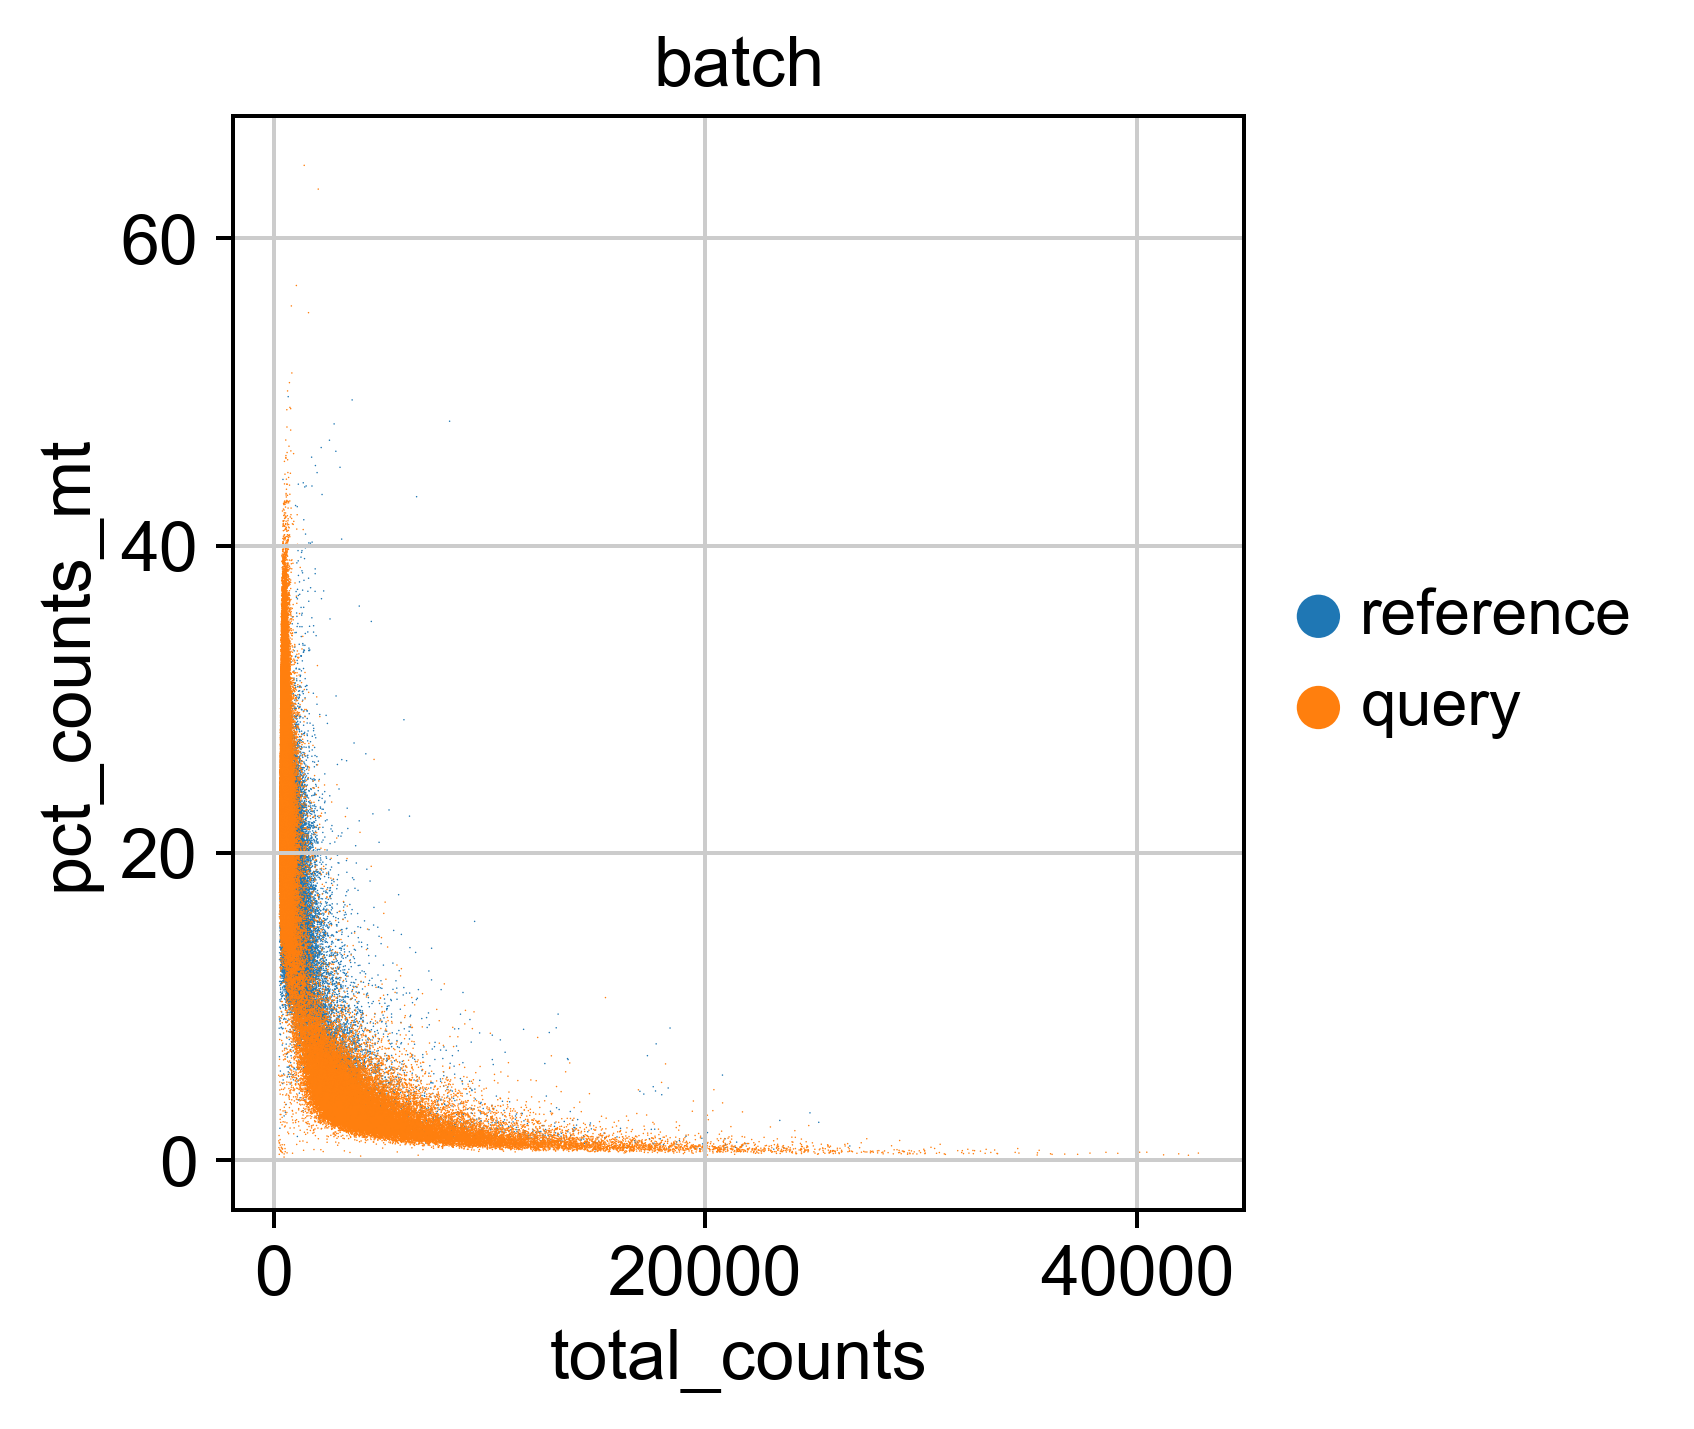

In [17]:
sc.pl.scatter(adata, x = 'total_counts', y = 'pct_counts_mt', color = "batch", frameon = False)

In [18]:
adata

AnnData object with n_obs × n_vars = 334961 × 32285
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'batch_colors'
    layers: 'counts', 'sqrt_norm'

In [19]:
adata = adata[adata.obs['total_counts'] > 500]
adata = adata[adata.obs['total_counts'] < 60000]
adata = adata[adata.obs['n_genes'] > 200]
adata = adata[adata.obs['n_genes'] < 6000]
adata = adata[adata.obs['doublet_scores'] < 0.35]
adata

View of AnnData object with n_obs × n_vars = 219989 × 32285
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'batch_colors'
    layers: 'counts', 'sqrt_norm'

In [20]:
adata.obs['genotype'].value_counts()

WT         124735
MdxSCID     56595
Mdx         38659
Name: genotype, dtype: int64

In [21]:
adata.obs['sample'].value_counts()

A9_2     69596
A10_2    55139
B1_2     39715
A11_2    22278
B2_2     16880
A12_2    16381
Name: sample, dtype: int64

### Select HVGs

In [22]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "sample",
    subset = True
)
adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 219989 × 7000
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'batch_colors', 'hvg'
    layers: 'counts', 'sqrt_norm'

### Transfer of annotation with scANVI

In [23]:
scvi.model.SCVI.setup_anndata(adata, 
categorical_covariate_keys = ["sample"], 
labels_key = "seed_labels", 
layer = 'counts')

In [24]:
scvi_model = scvi.model.SCVI(adata, n_latent = 50, n_layers = 3, dispersion = 'gene-batch', gene_likelihood = 'nb')

In [25]:
scvi_model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/36:   0%|          | 0/36 [00:00<?, ?it/s]

### Label transfer with `scANVI` 

In [ ]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [ ]:
scanvi_model.train()

In [ ]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

- Extract latent representation

In [ ]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

- Visualise corrected dataset

In [ ]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.3, spread = 4, random_state = 1712)
sc.pl.umap(adata, frameon = False, color = ['sample', 'genotype', 'C_scANVI', 'seed_labels'], size = 0.6, legend_fontsize = 5, ncols = 4)

In [ ]:
sc.pl.umap(adata, frameon = False, color = ['SMK', 'n_genes', 'doublet_scores', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_counts', 'sample_group', 'IAV_score'], size = 1, legend_fontsize = 5, ncols = 4, cmap = 'plasma')

### Compute integration metrics

In [ ]:
bm = Benchmarker(
    adata,
    batch_key = ["illumina_stimunr", "donor", "sample_group"],
    label_key = "C_scANVI",
    embedding_obsm_keys = ["X_pca", "X_scVI", "X_scANVI"],
    n_jobs = -1,
)
bm.benchmark()

In [ ]:
bm.plot_results_table(min_max_scale = False)

### Export annotated sample object 

In [ ]:
adata.obs.index = pd.Index(['-'.join(idx.split('-')[:3]) for idx in adata.obs.index])
adata.obs.index

In [ ]:
adata_raw.obs.index = pd.Index(['-'.join(idx.split('-')[:3]) for idx in adata_raw.obs.index])
adata_raw.obs.index

In [ ]:
adata.obs_names

In [ ]:
adata.obs['C_scANVI'].cat.categories

In [ ]:
adata.obs['C_scANVI'].value_counts()

### Export annotated object with raw counts

In [ ]:
adata

In [ ]:
adata_raw

In [ ]:
adata_export = anndata.AnnData(X = adata_raw.X, obs = adata.obs, var = adata_raw.var)
adata_export.obsm['X_scVI'] = adata.obsm['X_scVI'].copy()
adata_export.obsm['X_umap'] = adata.obsm['X_umap'].copy()
adata_export.obsm['X_scANVI'] = adata.obsm['X_scANVI'].copy()
adata_export

In [ ]:
adata_export.write('../data/Marburg_All_ctl230330_scANVI_annot.raw.h5ad')